In [1]:
import glob    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from solardatatools import DataHandler
from solardatatools.solar_noon import energy_com
from solardatatools.signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd # sum_squares version
from solardatatools.signal_decompositions_l2norm import l2_l1d1_l2d2p365 as cvx_sd_l2norm
from solardatatools.algorithms.time_shifts import TimeShift

In [2]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [10]:
from multiprocess import Pool
from opt_functions import run_weight_scan

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# plot_heatmap(matrix='raw', flag='clear')
# plot_heatmap(matrix='filled', flag='bad')

# Check current time shift analysis in DataHandler 
# but manually fixing C1 weight from l2 norm optimization
## Cassandra datasets

# Get current decompositions and best c1s

In [4]:
paths = ["./cassandra/timeshifts/*.csv"]

best_c1s_dict = {}
l2_decomp = {}

true_list = []
for path in paths:
    for fname in glob.glob(path):
        print(fname)
        df = pd.read_csv(fname)
        
        from solardatatools import DataHandler
        dh = DataHandler(df, convert_to_ts=True)
        dh.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=True, solver="MOSEK")
        #dh.plot_time_shift_analysis_results()
        #plt.show()
        print(f"Timeshift: ", dh.time_shifts)
        
        if dh.time_shifts:
            true_list.append(fname)
            best_c1s_dict[fname] = dh.time_shift_analysis.best_c1
            l2_decomp[fname] = (dh.time_shift_analysis.s1, dh.time_shift_analysis.s2)

./cassandra/timeshifts/TABF01017766.csv
total time: 16.22 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.52s
Cleaning                   7.91s
Filtering/Summarizing      2.79s
    Data quality           0.46s
    Clear day detect       0.56s
    Clipping detect        0.24s
    Capacity change detect 1.52s

Timeshift:  True
./cassandra/timeshifts/TACLC1036521.csv
total time: 14.94 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.13s
Cleaning                   7.03s
Filtering/Summarizing      2.77s
    Data quality           0.37s
    Clear day detect       0.89s
    Clipping detect        0.23s
    Capacity change detect 1.29s

Timeshift:  False
./cassandra/timeshifts/TABGC1044151.csv
total time: 16.92 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.59s
Cleaning                   8.07s
Filtering

Traceback (most recent call last):
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 429, in run_pipeline
    self.auto_fix_time_shifts(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 964, in auto_fix_time_shifts
    self.time_shift_analysis.run(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/algorithms/time_shifts.py", line 73, in run
    hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/algorithms/time_shifts.py", line 200, in optimize_c1
    best_ix = subset_ixs[np.nanargmin(hn[subset_ixs])]
  File "<__array_function__ internals>", line 180, in nanargmin
  File "/Users/smiskov/opt/anaconda3/envs/pvi-dev-sara/lib/python3.10/site-packages/numpy/lib/nanfunctions.py", line 553, in nanargmin
    raise ValueError("All-NaN slice encountered")
ValueError: All-NaN slice e

total time: 21.38 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.94s
Cleaning                   13.65s
Filtering/Summarizing      2.80s
    Data quality           0.39s
    Clear day detect       0.96s
    Clipping detect        0.23s
    Capacity change detect 1.22s

Timeshift:  None
./cassandra/timeshifts/TAEHC1001689.csv
total time: 11.25 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.77s
Cleaning                   5.67s
Filtering/Summarizing      1.81s
    Data quality           0.27s
    Clear day detect       0.44s
    Clipping detect        0.23s
    Capacity change detect 0.86s

Timeshift:  True
./cassandra/timeshifts/TABD01110568.csv
total time: 16.62 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.75s
Cleaning                   7.76s
Filtering/Summarizing      3.11s
    Data quality

In [5]:
print(true_list)

['./cassandra/timeshifts/TABF01017766.csv', './cassandra/timeshifts/TABGC1044151.csv', './cassandra/timeshifts/TABB01125140.csv', './cassandra/timeshifts/TABA01148025.csv', './cassandra/timeshifts/TACHC1020772.csv', './cassandra/timeshifts/TACHC1022171.csv', './cassandra/timeshifts/TACHC1022158.csv', './cassandra/timeshifts/TADBC1077912.csv', './cassandra/timeshifts/TAAJ01021775.csv', './cassandra/timeshifts/TAEHC1001689.csv', './cassandra/timeshifts/TABD01110568.csv']


# Optimize C2 

### Good region for c2 with sumsquares looks like 1e4 to 1e6

In [9]:
results = {}

In [11]:
weight_iter = np.logspace(3.5, 4.9, 50) # original c2=500

def run(sig):
    mae_list_s1 = []
    mae_list_s2 = []
    best_c1 = best_c1s_dict[sig]
    l2_decomp_s1 = l2_decomp[sig][0]
    l2_decomp_s2 = l2_decomp[sig][0]
    
    df = pd.read_csv(sig)
#     for w in tqdm(weight_iter):
#         from solardatatools import DataHandler
#         dh2 = DataHandler(df, convert_to_ts=True)
#         dh2.l2norm = False 
#         dh2.run_pipeline(power_col=dh2.keys[0][-1], fix_shifts=True, verbose=False, c1=best_c1s_dict[sig], c2=w, solver="MOSEK")
#         # print(dh2.time_shifts)
#         # dh2.plot_time_shift_analysis_results()
#         # plt.show()

#         mae_list_s1.append(mae(dh2.time_shift_analysis.s1, l2_decomp[sig][0]))
#         mae_list_s2.append(mae(dh2.time_shift_analysis.s2, l2_decomp[sig][1]))

    max_pool = 5

    with Pool(max_pool) as p:
        pool_outputs = list(
            tqdm(
                p.imap(run_weight_scan,
                       
                      zip(weight_iter, 
                         repeat(df),
                         repeat(mae_list_s1)
                         repeat(mae_list_s2),
                         repeat(best_c1),
                         repeat(l2_decomp_s1), 
                         repeat(l2_decomp_s2),
                               ),
                total=len(weight_iter)
            )
        ) 

        
    return weight_iter[np.argmin(mae_list_s1)], np.min(mae_list_s1), mae_list_s1, \
weight_iter[np.argmin(mae_list_s2)], np.min(mae_list_s2), mae_list_s2

SyntaxError: '(' was never closed (3922139737.py, line 26)

TABF01017766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:35<00:00, 11.50s/it]


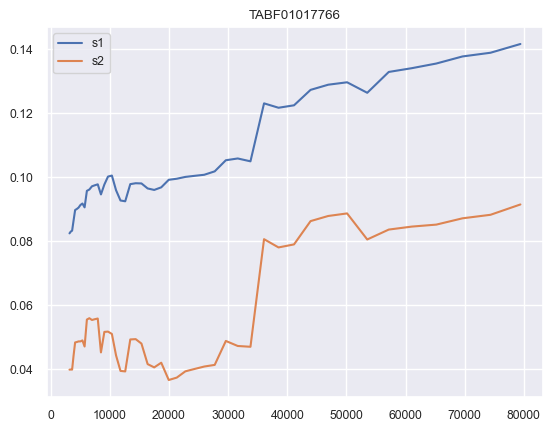

TABGC1044151


 42%|████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 21/50 [04:08<05:47, 11.97s/it]

In [ ]:
for path in true_list:
    print(path[23:-4])
    r = run(path)
    
    results[f"{path}_weight_min_s1"] =  r[0]
    results[f"{path}_mae_min_s1"] = r[1]
    results[f"{path}_mae_list_s1"] = r[2]
    
    results[f"{path}_weight_min_s2"] =  r[3]
    results[f"{path}_mae_min_s2"] = r[4]
    results[f"{path}_mae_list_s2"] = r[5]
    
    plt.plot(weight_iter, results[f"{path}_mae_list_s1"], label="s1")
    plt.plot(weight_iter, results[f"{path}_mae_list_s2"], label="s2")
    plt.legend()
    plt.title(path[23:-4])
    plt.show()

In [45]:
w_list_s1 = []
for path in ts_paths:
    print(path[23:-4], f'{results[f"{path}_weight_min_s1"]:.2f}')
    w_list.append(results[f"{path}_weight_min_s1"])

TABB01125140 106800.04
TACHC1022171 270802.74
TACHC1022158 163021.50
TADKC1043718 82864.28
TAAJ01021775 201410.28


In [52]:
w_list_s2 = []
for path in ts_paths:
    print(path[23:-4], f'{results[f"{path}_weight_min_s2"]:.2f}')
    w_list.append(results[f"{path}_weight_min_s2"])

TABB01125140 82864.28
TACHC1022171 143596.17
TACHC1022158 90178.30
TADKC1043718 82864.28
TAAJ01021775 79432.82


In [53]:
np.median(w_list)

82864.27728546843

In [24]:
for path in true_list:
    print(path[23:-4], f'{results[f"{path}_weight_min_s2"]:.2f}')

TABB01125140 33614.81


KeyError: './cassandra/timeshifts/TACHC1022171.csv_weight_min_s2'

TABB01125140
L2 norm
Timeshift: True


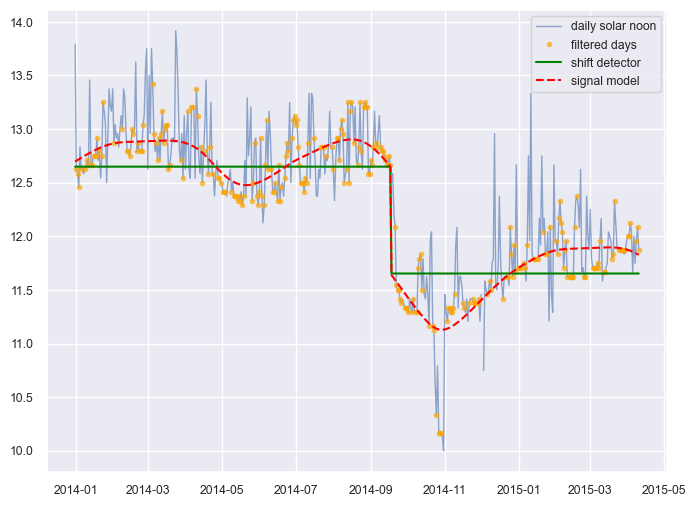

total time: 5.64 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.84s
Cleaning                   3.01s
Filtering/Summarizing      0.79s
    Data quality           0.08s
    Clear day detect       0.15s
    Clipping detect        0.16s
    Capacity change detect 0.39s

SS


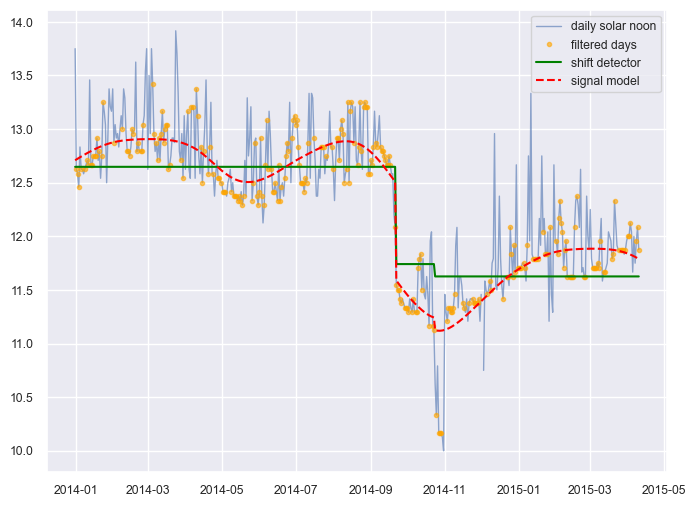

In [95]:
for path in true_list:
    print(path[23:-4])

    df = pd.read_csv(path)
    
    from solardatatools import DataHandler
    dh = DataHandler(df, convert_to_ts=True)
    #dh.l2norm = True 
    
    dh.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=False, solver="MOSEK")#, c1=5, c2=500)
    print("L2 norm")
    print(f"Timeshift: {dh.time_shifts}")
    dh.plot_time_shift_analysis_results()
    l2_decomp[path] = (dh.time_shift_analysis.s1, dh.time_shift_analysis.s2)
    plt.show()
    
    
    from solardatatools import DataHandler
    dh2 = DataHandler(df, convert_to_ts=True)
    dh2.l2norm = False 
    dh2.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=True, c2=63991.52, solver="MOSEK")
    print("SS")
    dh2.plot_time_shift_analysis_results()
    plt.show()
    
    break